Reference: https://realpython.com/python-keras-text-classification/

In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import random
import pickle
from collections import Counter
from os import listdir
from os.path import isfile, join
import pandas as pd

In [8]:
def get_data(posloc, negloc):
    lexicon = []
    count_of_files = 0
    df = pd.DataFrame()
    label = {posloc: 1, negloc: 0}
    for fl in [posloc, negloc]:
        onlyfiles = [f for f in listdir(fl) if isfile(join(fl, f))]
        for filename in onlyfiles:
            df1 = pd.DataFrame()
            count_of_files += 1
            with open(join(fl, filename)) as f:
                content = f.readlines()
                df1['text'] = content
                df1['label'] = [label[fl] for _ in content]
            df = pd.concat([df, df1])
    return df

In [9]:
df = get_data('txt_sentoken/pos/', 'txt_sentoken/neg/')

In [12]:
df.shape

(64720, 2)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [15]:
sentences = df['text'].values
y = df['label'].values

In [16]:
sentences_train, sentences_test, y_train, y_test = train_test_split(
    sentences, y, test_size=0.25, random_state=1000)

In [17]:
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [18]:
X_train = vectorizer.transform(sentences_train)
X_test = vectorizer.transform(sentences_test)

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

/Users/joydeep/roam/analysis_notebooks/experiments/develop/2018-07-17-Neo4j-Fetch_Edges-and-Nodes/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [21]:
print('Accuracy', score)

Accuracy 0.6936959208899877


### Keras

In [22]:
from keras.models import Sequential
from keras import layers

In [24]:
input_dim = X_train.shape[1]

In [25]:
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [26]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                359050    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 359,061
Trainable params: 359,061
Non-trainable params: 0
_________________________________________________________________


In [41]:
batch_size = 10
epochs = 2

In [42]:
history = model.fit(X_train, y_train, epochs=epochs, 
#                     verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size)

Train on 48540 samples, validate on 16180 samples
Epoch 1/2
48540/48540 [==============================] - 116s 2ms/step - loss: 0.3056 - acc: 0.8630 - val_loss: 0.7398 - val_acc: 0.6917
Epoch 2/2
48540/48540 [==============================] - 116s 2ms/step - loss: 0.2557 - acc: 0.8887 - val_loss: 0.8386 - val_acc: 0.6923


In [43]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [44]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

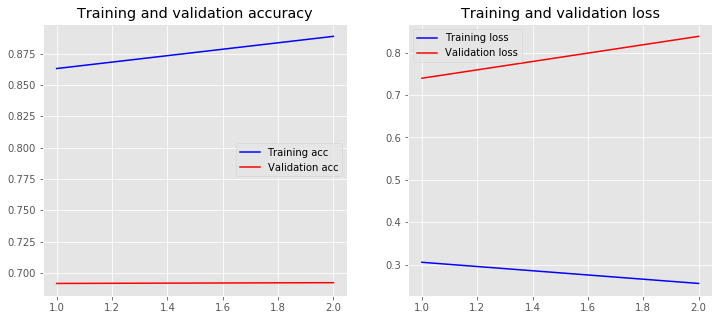

In [45]:
plot_history(history)

### Word Embeddings

In [46]:
from keras.preprocessing.text import Tokenizer

In [47]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

In [48]:
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

In [52]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

38906


In [50]:
print(sentences_train[2])

i hate those scenes in every movie where he goes around , bullying people up , saying stupid lines with a brooklyn accent more fake than burt reynold's hairpiece in " boogie nights . " 



In [51]:
print(X_train[2])

[18, 1127, 139, 111, 7, 145, 25, 99, 17, 219, 158, 101, 42, 811, 560, 425, 11, 2, 1620, 43, 1722, 58, 7, 2184, 1426]


In [53]:
# out of vocabulary words
word = 'afdgajksgdf'
print('{}: {}'.format(word, tokenizer.word_index[word]))

KeyError: 'afdgajksgdf'

In [54]:
from keras.preprocessing.sequence import pad_sequences

In [55]:
maxlen = 100

In [56]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [57]:
print(X_train[0, :])

[  3 102 143  49 273  45  18 679 284  31  26 430   5  22  10 926  10  36
 526 173  29  35 110   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [58]:
from keras.models import Sequential
from keras import layers

In [59]:
embedding_dim = 50

In [60]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [61]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [62]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           1945300   
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 1,995,321
Trainable params: 1,995,321
Non-trainable params: 0
_________________________________________________________________


In [63]:
epochs = 2
batch_size = 10

history = model.fit(X_train, y_train, epochs=epochs, 
                    validation_data=(X_test, y_test),
                    batch_size=batch_size)

Train on 48540 samples, validate on 16180 samples
Epoch 1/2
48540/48540 [==============================] - 183s 4ms/step - loss: 0.6404 - acc: 0.6259 - val_loss: 0.6164 - val_acc: 0.6583
Epoch 2/2
48540/48540 [==============================] - 189s 4ms/step - loss: 0.5075 - acc: 0.7486 - val_loss: 0.6581 - val_acc: 0.6423


In [64]:
loss, accuracy = model.evaluate(X_train, y_train)
print(loss, accuracy)

48540/48540 [==============================] - 7s 153us/step
0.3370450616791556 0.8822414503453149


In [65]:
loss, accuracy = model.evaluate(X_test , y_test)
print(loss, accuracy)

16180/16180 [==============================] - 2s 147us/step
0.6580698849833645 0.642274412855377


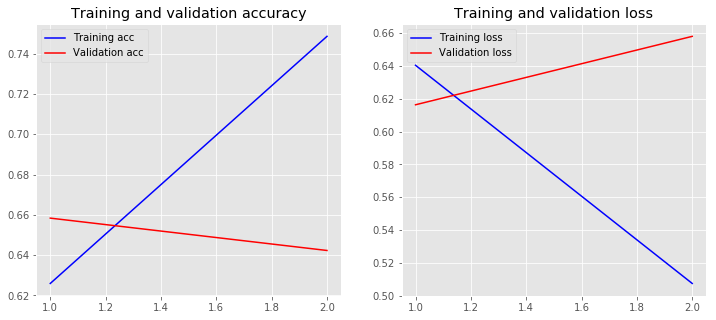

In [67]:
plot_history(history)

### Maxpooling

In [69]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50


model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           1945300   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 1,945,821
Trainable params: 1,945,821
Non-trainable params: 0
_________________________________________________________________


In [71]:
epochs = 2
batch_size = 10

history = model.fit(X_train, y_train, epochs=epochs, 
                    validation_data=(X_test, y_test),
                    batch_size=batch_size)

oss, accuracy = model.evaluate(X_train, y_train)
print('Training loss and accuracy', loss, accuracy)

loss, accuracy = model.evaluate(X_test , y_test)
print('Testing loss and accuracy', loss, accuracy)

Train on 48540 samples, validate on 16180 samples
Epoch 1/2
48540/48540 [==============================] - 175s 4ms/step - loss: 0.6422 - acc: 0.6261 - val_loss: 0.6202 - val_acc: 0.6475
Epoch 2/2
48540/48540 [==============================] - 1s 27us/step
Training loss and accuracy 0.6580698849833645 0.7710754017452669
16180/16180 [==============================] - 0s 27us/step
Testing loss and accuracy 0.6176055856629267 0.6631644004797022


### Pretrained embeddings

from https://fasttext.cc/docs/en/aligned-vectors.html

In [72]:
!wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.align.vec

--2018-11-05 16:29:29--  https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.align.vec
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 54.231.236.25
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|54.231.236.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5685446378 (5.3G) [binary/octet-stream]
Saving to: ‘wiki.en.align.vec’

wiki.en.align.vec     0%[                    ]  18.10M   267KB/s    eta 7h 36m ^C


In [84]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    with open(filepath) as f:
        next(f)
        for line in f:
            thisline = line.split()
            word, vector = thisline[:len(thisline)-300], thisline[-300:]
            word = " ".join(word)
            assert len(vector) == 300
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    
    return embedding_matrix

embedding_file = '/Users/joydeep/thinking/data/wiki.simple.vec'
embedding_dim = 300
embedding_matrix = create_embedding_matrix(embedding_file, tokenizer.word_index, embedding_dim)

In [89]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print('Number of words which have an embedding {}%'.format(100 * nonzero_elements / vocab_size))

Number of words which have an embedding 66.47046728011104%


In [95]:
from keras.models import Sequential
from keras import layers

embedding_dim = 300


model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                           weights = [embedding_matrix],
                           input_length=maxlen,
#                            trainable=True))
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 300)          11671800  
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 300)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                3010      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 11,674,821
Trainable params: 3,021
Non-trainable params: 11,671,800
_________________________________________________________________


In [96]:
epochs = 2
batch_size = 10

history = model.fit(X_train, y_train, epochs=epochs, 
                    validation_data=(X_test, y_test),
                    batch_size=batch_size)

oss, accuracy = model.evaluate(X_train, y_train)
print('Training loss and accuracy', loss, accuracy)

loss, accuracy = model.evaluate(X_test , y_test)
print('Testing loss and accuracy', loss, accuracy)

Train on 48540 samples, validate on 16180 samples
Epoch 1/2
48540/48540 [==============================] - 11s 221us/step - loss: 0.6893 - acc: 0.5364 - val_loss: 0.6820 - val_acc: 0.5663
Epoch 2/2
48540/48540 [==============================] - 2s 50us/step
Training loss and accuracy 0.6855792429450122 0.5412443345546919
16180/16180 [==============================] - 1s 49us/step
Testing loss and accuracy 0.6926070545600872 0.5427070457502113


### CNN

In [97]:
embedding_dim = 300


model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim,
#                            weights = [embedding_matrix],
                           input_length=maxlen,
#                            trainable=True))
#                            trainable=False))
                          ))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 300)          11671800  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           192128    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 11,865,229
Trainable params: 11,865,229
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 2
batch_size = 10

history = model.fit(X_train, y_train, epochs=epochs, 
                    validation_data=(X_test, y_test),
                    batch_size=batch_size)

oss, accuracy = model.evaluate(X_train, y_train)
print('Training loss and accuracy', loss, accuracy)

loss, accuracy = model.evaluate(X_test , y_test)
print('Testing loss and accuracy', loss, accuracy)

Train on 48540 samples, validate on 16180 samples
Epoch 1/2
 5630/48540 [==>...........................] - ETA: 32:14 - loss: 0.6858 - acc: 0.5474

I am reaching the end of my laptop configuration

Its too slow now